In [ ]:
# Intallation packages before use Jupyter

# !pip install pandas
# !pip install -U scikit-learn
# !pip install keras
# !pip install matplotlib
# !pip install kaleido
# !pip install plotly

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
# from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model
from keras.metrics import Precision, Accuracy
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras.optimizers import schedules
from math import sqrt
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# be able to save images on server
matplotlib.use('Agg')

# Not show warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# !pip install -U kaleido # w Google Colab wymagany Runtime restart po instalacji (Runtime -> Restart Runtime)
import kaleido #required
# kaleido.__version__ #0.2.1

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


2024-07-07 23:14:07.160085: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-07 23:14:07.180543: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-07 23:14:07.180568: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-07 23:14:07.194020: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.16.2
Num GPUs Available:  1


In [2]:
# Zip
# importing the "tarfile" module
import tarfile # type: ignore

# open file
file = tarfile.open('2_150x9.tar.gz')

# extracting a specific file
file.extractall(path='./data/2_150x9/')

file.close()

In [3]:
# Data generator
def data(time, features):
    # Timestep 
    # timestepsPerSample = 20
    timestepsPerSample = time

    # Timesteps in input data
    timestepsPerSampleWholeData = 150

    # Replace 'your_file.csv' with the actual file path
    file_features = './data/2_150x9/2_150x9f.csv'
    file_labels = './data/2_150x9/2_150x9l.csv'

    # Read the .csv file and create an array
    data_strings = np.genfromtxt(file_features, delimiter=';')
    labels_strings = np.genfromtxt(file_labels,delimiter=';')


    # Wycinanie wybranych kolumn
    #  0    1         2             3        4       5        6    7        8
    # RSI, VWAP, HeikenResult, closeHeiken, CMF, Stochastic, OBV, QQE, TrendFilter
    # data_s = data_strings[:,[0,2,3,4,5,6,7,8]]
    if features == 0:
        data_s = data_strings[:,[0,4,5,8]]
    elif features == 1:
        data_s = data_strings[:,[0,1,4,5,6,8]]
    elif features == 2:
        data_s = data_strings[:,:]
        
    num_features = data_s.shape[1]
    # print(data_strings[:3])
    # print(data_s[:3])

    
    # Convert from strings to float and int
    X = data_s.astype(float).reshape((-1,timestepsPerSampleWholeData,num_features))
    Y = labels_strings.astype(float).reshape((-1,6))
    # print(X.shape)
    # print(Y.shape)

    # Modification from imported to new size X[samples,timesteps]
    X_mod = X[1000:11000,timestepsPerSampleWholeData - timestepsPerSample:]
    Y_mod = Y[1000:11000]
    timestepsPerSampleWholeData = X_mod.shape[1]
    # print(X_mod.shape)
    # print(Y_mod.shape)
    # print(X_mod[:1])

    # Splitting
    x_train, x_test, Y_train, Y_test = train_test_split(X_mod,Y_mod, test_size=0.15, shuffle=False)
    y_train = Y_train[:, 0:2]
    y_test = Y_test[:, 0:2]
    # print(y_train[:2])
    # print(y_test[:2])

    # Summarize
    num_samples = x_train.shape[0]
    test_samples = x_test.shape[0]
    print(f"Train shape: {x_train.shape}")
    print(f"Timesteps: {timestepsPerSampleWholeData}")
    print(f"Train Samples: {num_samples}")
    print(f"Test Samples: {test_samples}")
    print(f"Num features: {num_features}")
    return x_train, x_test, y_train, y_test, Y_test

In [92]:
# Data gen
timeStep = 150
features = 0

x_train, x_test, y_train, y_test, Y_test = data(timeStep, features)

Train shape: (8500, 150, 4)
Timesteps: 150
Train Samples: 8500
Test Samples: 1500
Num features: 4


In [70]:
# fit lstm model
from tabnanny import verbose

def shuffle_weights(model, weights=None):
    """Randomly permute the weights in `model`, or the given `weights`.
    This is a fast approximation of re-initializing the weights of a model.
    Assumes weights are distributed independently of the dimensions of the weight tensors
      (i.e., the weights have the same distribution along each dimension).
    :param Model model: Modify the weights of the given model.
    :param list(ndarray) weights: The model's weights will be replaced by a random permutation of these weights.
      If `None`, permute the model's current weights.
    """
    if weights is None:
        weights = model.get_weights()
    weights = [np.random.permutation(w.flat).reshape(w.shape) for w in weights]
    # Faster, but less random: only permutes along the first dimension
    # weights = [np.random.permutation(w) for w in weights]
    model.set_weights(weights)


def fit_lstmModel(i, x_train, y_train, x_test, y_test, batch_size, nb_epoch, neurons, time, denseType, dropout, modelVar, learning_rate):
    LstmLayer = LSTM(
    units=neurons,
    activation="tanh",
    recurrent_activation="sigmoid",
    use_bias=True, # true if cuDNN
    kernel_initializer="glorot_uniform",
    recurrent_initializer="orthogonal",
    bias_initializer="zeros",
    unit_forget_bias=True,
    kernel_regularizer=None,
    recurrent_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    recurrent_constraint=None,
    bias_constraint=None,
    dropout=dropout, # !important parameter for optimization => 0 if cuDNN
    recurrent_dropout=0.0,
    seed=None,
    return_sequences=False,
    return_state=False,
    go_backwards=False,
    stateful=False,
    unroll=False, # false if cuDNN
    input_shape=(x_train.shape[1],x_train.shape[2]),
    # input_dim=(x_train.shape[1])
    ) 

    if modelVar == 0:
        model = Sequential() # initializing model
        # input layer and LSTM layer with 50 neurons
        model.add(LstmLayer)
        # model.add(Dense(100, activation='relu'))
        # model.add(Dense(100, activation='relu'))
        # model.add(Dense(20, activation='relu'))
        # outpute layer with sigmoid activation
        model.add(Dense(y_train.shape[1], activation='sigmoid'))
        
    if modelVar == 1:
        model = Sequential()

        # Assuming `data` is your input matrix with shape (samples, time_steps, features)
        model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
        model.add(Dropout(dropout))

        model.add(LSTM(units=50, return_sequences=False))
        model.add(Dropout(dropout))

        model.add(Dense(units=25))
        model.add(Dropout(dropout))

        # Output layer for price prediction
        model.add(Dense(y_train.shape[1], activation='sigmoid'))

    elif modelVar == 2:
        model = Sequential()

        # Assuming `data` is your input matrix with shape (samples, time_steps, features)
        model.add(LSTM(units=150, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
        model.add(Dropout(dropout))

        model.add(LSTM(units=150, return_sequences=False))
        model.add(Dropout(dropout))

        model.add(Dense(units=75))
        model.add(Dropout(dropout))

        # Output layer for price prediction
        model.add(Dense(y_train.shape[1], activation='sigmoid'))

    elif modelVar == 3:
        model = Sequential()

        # Assuming `data` is your input matrix with shape (samples, time_steps, features)
        model.add(LSTM(units=300, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
        model.add(Dropout(dropout))

        model.add(LSTM(units=300, return_sequences=False))
        model.add(Dropout(dropout))

        model.add(Dense(units=150))
        model.add(Dropout(dropout))

        # Output layer for price prediction
        model.add(Dense(y_train.shape[1], activation='sigmoid'))

    elif modelVar == 4:
        model = Sequential()

        # Assuming `data` is your input matrix with shape (samples, time_steps, features)
        model.add(LSTM(units=1000, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
        model.add(Dropout(dropout))

        model.add(LSTM(units=1000, return_sequences=False))
        model.add(Dropout(dropout))

        model.add(Dense(units=500))
        model.add(Dropout(dropout))

        # Output layer for price prediction
        model.add(Dense(y_train.shape[1], activation='sigmoid'))
    
    # Callback Checkpoint
    checkpoint = ModelCheckpoint(
            filepath='./saved_models/last_saved_model.keras',
            save_best_only=True,
            monitor='val_loss',
            verbose=1
            )

    # Callback EarlyStopping
    earlyStopping = EarlyStopping(monitor='val_loss',
                                             start_from_epoch=5,
                                             restore_best_weights=True,
                                             verbose=0,
                                             patience=3)
    
    #  Callback profit
    profitList = list()
    
    class MyCallback(Callback):
        def on_epoch_end(self, epoch, logs=None):
            predict = model.predict(x_test, batch_size=batch_size)
            profit = funcProfit(predict, Y_test)
            
            if len(profitListSaveModel) == 0:
                model.save(f'./saved_models/best_model_{str(testingParameter)}_{str(time)}.keras')
                print(f"New best model saved, previous best profit -> First")
            elif profit > max(profitListSaveModel):
                model.save(f'./saved_models/best_model_{str(testingParameter)}_{str(time)}.keras')
                print(f"New best model saved, previous best profit -> {str(max(profitListSaveModel))}")
            
            profitList.append(profit)
            profitListSaveModel.append(profit)
            print(f"Profit: {profit}")


    # Optimizer
    num_samples = x_train.shape[0]
    STEPS_PER_EPOCH = num_samples/batch_size

    lr_schedule = schedules.InverseTimeDecay(
    # lr_schedule = schedules.ExponentialDecay(
    0.001,
    decay_steps=STEPS_PER_EPOCH*100,
    decay_rate=0.9,
    staircase=False)

    def get_optimizer():
         # return tf.keras.optimizers.Adam(learning_rate=0.001)
        # return tf.keras.optimizers.Adam() # type: ignore
        # return tf.keras.optimizers.RMSprop(learning_rate=learning_rate) # type: ignore
        return tf.keras.optimizers.Adam(learning_rate= lr_schedule) # type: ignore

    optimizer = get_optimizer()

    # defining loss function, optimizer, metrics and then compiling model
    model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
    # model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['precision'])

    # Save initial weights on first compile. In next compile restore initial weights
    if i == 0:
        model.save_weights("./saved_models/initial.weights.h5")
    elif i > 0:
        shuffle_weights(model, weights=None)
        
    model.summary()

    # fit model
    history = model.fit(x_train, y_train, epochs=nb_epoch, batch_size=batch_size, 
                        shuffle=False, validation_data=(x_test, y_test), callbacks=[checkpoint, earlyStopping, MyCallback()], verbose=2) # type: ignore
    
    # Convert list() to array
    profitArray = np.array(profitList)
    
    return model, history, profitArray

In [71]:
# Profit old
def funcProfitOld(predict, Y_test):
    predict_classes = np.where(predict > 0.5, 1,0)
    concat = np.hstack((predict_classes, Y_test[:,2:]))
    # df = pd.DataFrame(concat, columns=['Sell', 'Buy', 'Price'])
    df = pd.DataFrame(concat, columns=['Sell', 'Buy', 'Price', 'Open', 'High', 'Low'])

    # Absolute difference prices
    sum = 0
    for i in range(0, len(df)):
        if (i-1) > 0:
            diff = abs((df.at[i,'Sell'] - df.at[i-1,'Sell']))
            if diff < 0.5:
                if df.at[i,'Sell'] == 1:
                    sum += (df.at[i,'Price'] - df.at[i-1,'Price'])*(-1)
                elif df.at[i,'Buy'] == 1:
                    sum += (df.at[i,'Price'] - df.at[i-1,'Price'])
                if df.at[i,'Sell'] != df.at[i-1,'Sell']:
                    sum -= 0.03
    return sum


# Profit
def funcProfit(predict, Y_test):
    predict_classes = np.where(predict > 0.56, 1,0)
    concat = np.hstack((predict_classes, Y_test[:,2:]))
    # df = pd.DataFrame(concat, columns=['Sell', 'Buy', 'Price'])
    df = pd.DataFrame(concat, columns=['Sell', 'Buy', 'Close', 'Open', 'High', 'Low'])

    # Absolute difference prices
    spread = 0.03
    tp = 1000 # 0.20
    sum = 0
    sell = 0
    buy = 0
    for i in range(0, len(df)):
        if (i-1) >= 0:
            if df.at[i,'Sell'] > 0.8 and df.at[i-1,'Sell'] < 0.2:                  # S 0 1 
                if buy > 0:
                    sell = df.at[i,'Open'] - spread
                    sum += df.at[i,'Open'] - buy
                    buy = 0
                elif sell == 0:
                    sell = df.at[i,'Open'] - spread
            elif df.at[i,'Sell'] > 0.8 and df.at[i-1,'Sell'] > 0.8 and sell > 0:   # S 1 1 sell >0
                if df.at[i-1,'High'] >= (sell + tp):
                    sum -= tp
                    sell = 0
                if df.at[i-1,'Low'] <= (sell - tp):
                    sum += tp
                    sell = 0
# --------------------------------------------------------------------------------------------------------

            elif df.at[i,'Buy'] > 0.8 and df.at[i-1,'Buy'] < 0.2:               # B 0 1 
                if sell > 0:
                    buy = df.at[i,'Open'] + spread
                    sum += sell - df.at[i,'Open']
                    sell = 0
                elif buy == 0:
                    buy = df.at[i,'Open'] + spread
            elif df.at[i,'Buy'] > 0.8 and df.at[i-1,'Buy'] > 0.8 and buy > 0:   # B 1 1 buy >0
                if df.at[i-1,'Low'] <= (buy - tp):
                    sum -= tp
                    buy = 0
                if df.at[i-1,'High'] >= (buy + tp):
                    sum += tp
                    buy = 0

    return round(sum, 2)

In [72]:
# Experiment
def experiment(i, repeats, epochs, neurons, time, denseType, dropout, modelVar, features, learning_rate):
    # # Data gen
    # x_train, x_test, y_train, y_test, Y_test = data(time, features)

    # Evaluate declaration
    accuracy = list()
    profit = list()
    profitOld = list()
    metrics = list()

    # Repeats
    for r in range(repeats):
        print(f"Repeat {r} running...")
        # Batch size
        batch_size = 64
        # model
        model, history, profitArray = fit_lstmModel(i, x_train, y_train, x_test, y_test, batch_size, epochs, neurons, time, denseType, dropout, modelVar, learning_rate)
        i += 1
        
        # forecast the entire training dataset to build up state for forecasting
        model = load_model(filepath="./saved_models/last_saved_model.keras")
        predict = model.predict(x_test, batch_size=batch_size)
        test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0) # type: ignore

        metric = pd.DataFrame(history.history)
        metric['epoch'] = history.epoch

        # Add column Profit with profit result for epochs
        metric = metric.assign(Profit=profitArray)

        metrics.append(metric)
        accuracy.append(test_acc*100)
        profit.append(funcProfit(predict, Y_test))
        profitOld.append(funcProfitOld(predict, Y_test))
    
    return accuracy, profit, profitOld, metrics

In [73]:
# Output
def plotsOut(d, metrics):
    fig = make_subplots(rows=1, cols=3, subplot_titles=('Accuracy', 'Loss', 'Profit'))

    # Layout - set size
    fig.update_layout(
        autosize=True,
        width=1600,
        height=1000
    )

    for idx, m in enumerate(metrics):
        fig.add_trace(go.Scatter(x=m['epoch'], y=m['accuracy'], name=f'accuracy{str(idx)}', line_color='#0000ff', showlegend=False), row=1, col=1)
        fig.add_trace(go.Scatter(x=m['epoch'], y=m['loss'], name=f'loss{str(idx)}', line_color='#0000ff', showlegend=False), row=1, col=2)
        fig.add_trace(go.Scatter(x=m['epoch'], y=m['val_accuracy'], name=f'val_accuracy{str(idx)}', line_color='#EF8260', showlegend=False), row=1, col=1)
        fig.add_trace(go.Scatter(x=m['epoch'], y=m['val_loss'], name=f'val_loss{str(idx)}', line_color='#EF8260', showlegend=False), row=1, col=2)
        fig.add_trace(go.Scatter(x=m['epoch'], y=m['Profit'], name=f'profit{str(idx)}', line_color='#EF8260', showlegend=False), row=1, col=3)

    fig.update_xaxes(title_text='epochs')
    fig.update_yaxes(title_text='')
    # fig.update_layout(width=1000, title='Accuracy and Loss')
    fig.write_image(file=f"compare_models_{str(d)}.jpg", engine="kaleido")
    fig.show()

10 Timestep test start...
Train shape: (8500, 10, 4)
Timesteps: 10
Train Samples: 8500
Test Samples: 1500
Num features: 4
Repeat 0 running...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_61 (LSTM)                  │ (None, 10, 150)        │        93,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 10, 150)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_62 (LSTM)                  │ (None, 150)            │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_61 (Dropout)            │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 75)             │        11,325 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_62 (Dropout)            │ (None, 75)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 2)              │           152 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 285,077 (1.09 MB)

 Trainable params: 285,077 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40

Epoch 1: val_loss improved from inf to 0.62870, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
New best model saved, previous best profit -> First
Profit: 4.88
133/133 - 4s - 30ms/step - accuracy: 0.6200 - loss: 0.6590 - val_accuracy: 0.6707 - val_loss: 0.6287
Epoch 2/40

Epoch 2: val_loss improved from 0.62870 to 0.59442, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Profit: 4.13
133/133 - 2s - 12ms/step - accuracy: 0.6584 - loss: 0.6271 - val_accuracy: 0.6907 - val_loss: 0.5944
Epoch 3/40

Epoch 3: val_loss improved from 0.59442 to 0.57366, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Profit: 1.81
133/133 - 1s - 11ms/step - accuracy: 0.6767 - loss: 0.6077 - val_accuracy: 0.7073 - val_loss: 0.5737
Epoch 4/40

Epoch 4: val_loss improved from 0.57366 to 0.56157, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_64 (LSTM)                  │ (None, 10, 150)        │        93,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_63 (Dropout)            │ (None, 10, 150)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_65 (LSTM)                  │ (None, 150)            │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_64 (Dropout)            │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 75)             │        11,325 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_65 (Dropout)            │ (None, 75)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 2)              │           152 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 285,077 (1.09 MB)

 Trainable params: 285,077 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40

Epoch 1: val_loss improved from inf to 0.62656, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Profit: 4.08
133/133 - 4s - 32ms/step - accuracy: 0.5708 - loss: 0.6884 - val_accuracy: 0.6780 - val_loss: 0.6266
Epoch 2/40

Epoch 2: val_loss improved from 0.62656 to 0.58950, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Profit: 4.59
133/133 - 2s - 14ms/step - accuracy: 0.6651 - loss: 0.6240 - val_accuracy: 0.6893 - val_loss: 0.5895
Epoch 3/40

Epoch 3: val_loss improved from 0.58950 to 0.56284, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Profit: 1.85
133/133 - 2s - 14ms/step - accuracy: 0.6849 - loss: 0.6012 - val_accuracy: 0.7173 - val_loss: 0.5628
Epoch 4/40

Epoch 4: val_loss improved from 0.56284 to 0.55587, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Profit: 2.83
133/133 - 2s - 13ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_67 (LSTM)                  │ (None, 10, 150)        │        93,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_66 (Dropout)            │ (None, 10, 150)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_68 (LSTM)                  │ (None, 150)            │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_67 (Dropout)            │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 75)             │        11,325 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_68 (Dropout)            │ (None, 75)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 2)              │           152 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 285,077 (1.09 MB)

 Trainable params: 285,077 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40

Epoch 1: val_loss improved from inf to 0.64208, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Profit: 0.33
133/133 - 5s - 35ms/step - accuracy: 0.5638 - loss: 0.6922 - val_accuracy: 0.6620 - val_loss: 0.6421
Epoch 2/40

Epoch 2: val_loss improved from 0.64208 to 0.59453, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Profit: 6.25
133/133 - 2s - 12ms/step - accuracy: 0.6626 - loss: 0.6282 - val_accuracy: 0.6887 - val_loss: 0.5945
Epoch 3/40

Epoch 3: val_loss improved from 0.59453 to 0.56765, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Profit: 2.69
133/133 - 2s - 13ms/step - accuracy: 0.6819 - loss: 0.6056 - val_accuracy: 0.7120 - val_loss: 0.5676
Epoch 4/40

Epoch 4: val_loss improved from 0.56765 to 0.55755, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Profit: 2.67
133/133 - 2s - 13m

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_70 (LSTM)                  │ (None, 10, 150)        │        93,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_69 (Dropout)            │ (None, 10, 150)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_71 (LSTM)                  │ (None, 150)            │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_70 (Dropout)            │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 75)             │        11,325 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_71 (Dropout)            │ (None, 75)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 2)              │           152 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 285,077 (1.09 MB)

 Trainable params: 285,077 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40

Epoch 1: val_loss improved from inf to 0.63327, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Profit: 1.87
133/133 - 4s - 31ms/step - accuracy: 0.5601 - loss: 0.6866 - val_accuracy: 0.6720 - val_loss: 0.6333
Epoch 2/40

Epoch 2: val_loss improved from 0.63327 to 0.58947, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Profit: 4.27
133/133 - 1s - 11ms/step - accuracy: 0.6647 - loss: 0.6250 - val_accuracy: 0.6907 - val_loss: 0.5895
Epoch 3/40

Epoch 3: val_loss improved from 0.58947 to 0.56193, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Profit: 1.41
133/133 - 2s - 13ms/step - accuracy: 0.6847 - loss: 0.6011 - val_accuracy: 0.7180 - val_loss: 0.5619
Epoch 4/40

Epoch 4: val_loss improved from 0.56193 to 0.55595, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Profit: 2.03
133/133 - 2s - 13ms/s

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_73 (LSTM)                  │ (None, 10, 150)        │        93,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_72 (Dropout)            │ (None, 10, 150)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_74 (LSTM)                  │ (None, 150)            │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_73 (Dropout)            │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 75)             │        11,325 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_74 (Dropout)            │ (None, 75)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 2)              │           152 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 285,077 (1.09 MB)

 Trainable params: 285,077 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40

Epoch 1: val_loss improved from inf to 0.62952, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Profit: 5.56
133/133 - 4s - 32ms/step - accuracy: 0.5664 - loss: 0.6879 - val_accuracy: 0.6753 - val_loss: 0.6295
Epoch 2/40

Epoch 2: val_loss improved from 0.62952 to 0.58965, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Profit: 4.29
133/133 - 2s - 14ms/step - accuracy: 0.6633 - loss: 0.6244 - val_accuracy: 0.6880 - val_loss: 0.5896
Epoch 3/40

Epoch 3: val_loss improved from 0.58965 to 0.56366, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Profit: 1.67
133/133 - 2s - 13ms/step - accuracy: 0.6855 - loss: 0.6023 - val_accuracy: 0.7153 - val_loss: 0.5637
Epoch 4/40

Epoch 4: val_loss improved from 0.56366 to 0.55664, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Profit: 1.89
133/133 - 2s - 13ms

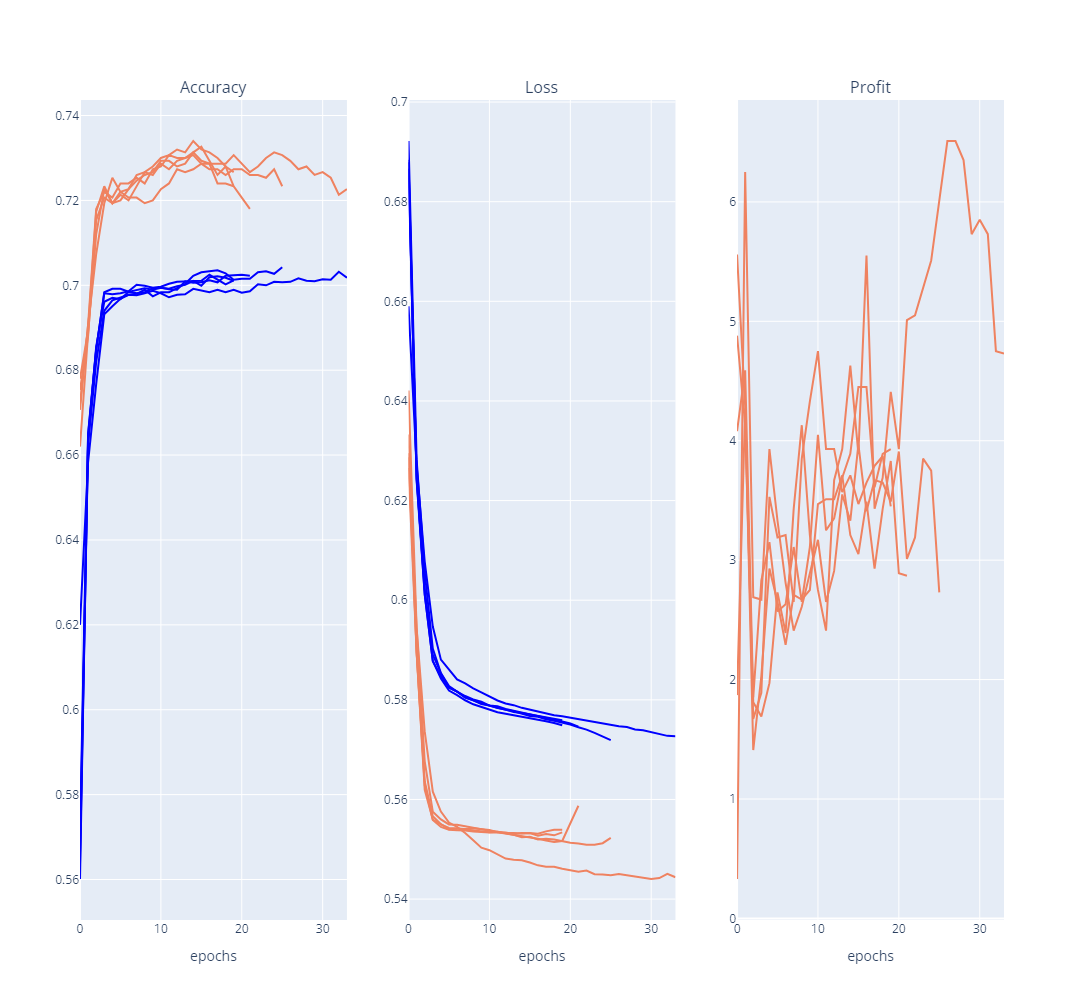

20 Timestep test start...
Train shape: (8500, 20, 4)
Timesteps: 20
Train Samples: 8500
Test Samples: 1500
Num features: 4
Repeat 0 running...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_76 (LSTM)                  │ (None, 20, 150)        │        93,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_75 (Dropout)            │ (None, 20, 150)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_77 (LSTM)                  │ (None, 150)            │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_76 (Dropout)            │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 75)             │        11,325 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_77 (Dropout)            │ (None, 75)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 2)              │           152 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 285,077 (1.09 MB)

 Trainable params: 285,077 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40

Epoch 1: val_loss improved from inf to 0.63179, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
New best model saved, previous best profit -> First
Profit: 1.05
133/133 - 4s - 33ms/step - accuracy: 0.6146 - loss: 0.6597 - val_accuracy: 0.6727 - val_loss: 0.6318
Epoch 2/40

Epoch 2: val_loss improved from 0.63179 to 0.59841, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
New best model saved, previous best profit -> 1.05
Profit: 4.33
133/133 - 2s - 16ms/step - accuracy: 0.6548 - loss: 0.6270 - val_accuracy: 0.6860 - val_loss: 0.5984
Epoch 3/40

Epoch 3: val_loss improved from 0.59841 to 0.57927, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Profit: 2.87
133/133 - 2s - 15ms/step - accuracy: 0.6712 - loss: 0.6125 - val_accuracy: 0.7000 - val_loss: 0.5793
Epoch 4/40

Epoch 4: val_loss improved from 0.57927 to 0.56383, saving model to ./saved

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_79 (LSTM)                  │ (None, 20, 150)        │        93,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_78 (Dropout)            │ (None, 20, 150)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_80 (LSTM)                  │ (None, 150)            │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_79 (Dropout)            │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 75)             │        11,325 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_80 (Dropout)            │ (None, 75)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 2)              │           152 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 285,077 (1.09 MB)

 Trainable params: 285,077 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40

Epoch 1: val_loss improved from inf to 0.63905, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Profit: 3.78
133/133 - 4s - 34ms/step - accuracy: 0.5605 - loss: 0.6901 - val_accuracy: 0.6727 - val_loss: 0.6391
Epoch 2/40

Epoch 2: val_loss improved from 0.63905 to 0.59453, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Profit: 3.83
133/133 - 2s - 15ms/step - accuracy: 0.6612 - loss: 0.6276 - val_accuracy: 0.6873 - val_loss: 0.5945
Epoch 3/40

Epoch 3: val_loss improved from 0.59453 to 0.56688, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Profit: 3.25
133/133 - 2s - 14ms/step - accuracy: 0.6812 - loss: 0.6054 - val_accuracy: 0.7127 - val_loss: 0.5669
Epoch 4/40

Epoch 4: val_loss improved from 0.56688 to 0.55890, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Profit: 2.89
133/133 - 2s - 14ms/

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_82 (LSTM)                  │ (None, 20, 150)        │        93,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_81 (Dropout)            │ (None, 20, 150)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_83 (LSTM)                  │ (None, 150)            │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_82 (Dropout)            │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 75)             │        11,325 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_83 (Dropout)            │ (None, 75)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 2)              │           152 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 285,077 (1.09 MB)

 Trainable params: 285,077 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40

Epoch 1: val_loss improved from inf to 0.62974, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
New best model saved, previous best profit -> 4.39
Profit: 4.43
133/133 - 4s - 33ms/step - accuracy: 0.5704 - loss: 0.6865 - val_accuracy: 0.6753 - val_loss: 0.6297
Epoch 2/40

Epoch 2: val_loss improved from 0.62974 to 0.59086, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
New best model saved, previous best profit -> 4.43
Profit: 4.59
133/133 - 2s - 15ms/step - accuracy: 0.6620 - loss: 0.6255 - val_accuracy: 0.6867 - val_loss: 0.5909
Epoch 3/40

Epoch 3: val_loss improved from 0.59086 to 0.56477, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Profit: 3.27
133/133 - 2s - 14ms/step - accuracy: 0.6860 - loss: 0.6032 - val_accuracy: 0.7160 - val_loss: 0.5648
Epoch 4/40

Epoch 4: val_loss improved from 0.56477 to 0.55719, saving model to ./saved_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_85 (LSTM)                  │ (None, 20, 150)        │        93,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_84 (Dropout)            │ (None, 20, 150)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_86 (LSTM)                  │ (None, 150)            │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_85 (Dropout)            │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 75)             │        11,325 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_86 (Dropout)            │ (None, 75)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 2)              │           152 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 285,077 (1.09 MB)

 Trainable params: 285,077 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40

Epoch 1: val_loss improved from inf to 0.62741, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
New best model saved, previous best profit -> 5.27
Profit: 5.48
133/133 - 4s - 30ms/step - accuracy: 0.5578 - loss: 0.6875 - val_accuracy: 0.6747 - val_loss: 0.6274
Epoch 2/40

Epoch 2: val_loss improved from 0.62741 to 0.59169, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Profit: 3.99
133/133 - 2s - 14ms/step - accuracy: 0.6618 - loss: 0.6251 - val_accuracy: 0.6860 - val_loss: 0.5917
Epoch 3/40

Epoch 3: val_loss improved from 0.59169 to 0.56429, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Profit: 4.29
133/133 - 2s - 15ms/step - accuracy: 0.6836 - loss: 0.6038 - val_accuracy: 0.7207 - val_loss: 0.5643
Epoch 4/40

Epoch 4: val_loss improved from 0.56429 to 0.55701, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_88 (LSTM)                  │ (None, 20, 150)        │        93,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_87 (Dropout)            │ (None, 20, 150)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_89 (LSTM)                  │ (None, 150)            │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_88 (Dropout)            │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 75)             │        11,325 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_89 (Dropout)            │ (None, 75)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 2)              │           152 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 285,077 (1.09 MB)

 Trainable params: 285,077 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40

Epoch 1: val_loss improved from inf to 0.63071, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Profit: 2.71
133/133 - 5s - 34ms/step - accuracy: 0.5658 - loss: 0.6889 - val_accuracy: 0.6720 - val_loss: 0.6307
Epoch 2/40

Epoch 2: val_loss improved from 0.63071 to 0.59063, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Profit: 4.11
133/133 - 2s - 15ms/step - accuracy: 0.6626 - loss: 0.6241 - val_accuracy: 0.6893 - val_loss: 0.5906
Epoch 3/40

Epoch 3: val_loss improved from 0.59063 to 0.56470, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Profit: 3.03
133/133 - 2s - 16ms/step - accuracy: 0.6852 - loss: 0.6022 - val_accuracy: 0.7133 - val_loss: 0.5647
Epoch 4/40

Epoch 4: val_loss improved from 0.56470 to 0.55856, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Profit: 2.37
133/133 - 2s - 16ms/

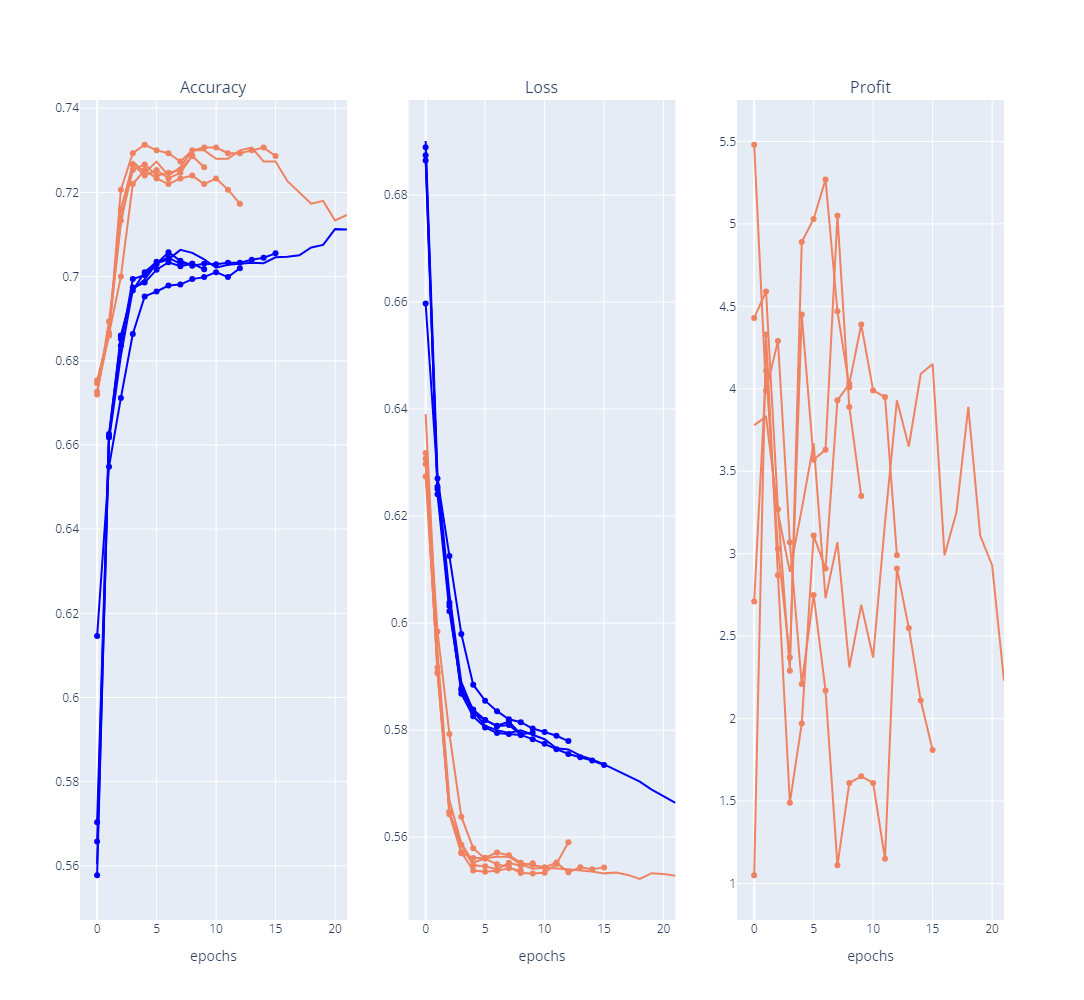

50 Timestep test start...
Train shape: (8500, 50, 4)
Timesteps: 50
Train Samples: 8500
Test Samples: 1500
Num features: 4
Repeat 0 running...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_91 (LSTM)                  │ (None, 50, 150)        │        93,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_90 (Dropout)            │ (None, 50, 150)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_92 (LSTM)                  │ (None, 150)            │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_91 (Dropout)            │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 75)             │        11,325 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_92 (Dropout)            │ (None, 75)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 2)              │           152 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 285,077 (1.09 MB)

 Trainable params: 285,077 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40

Epoch 1: val_loss improved from inf to 0.63010, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
New best model saved, previous best profit -> First
Profit: 3.0
133/133 - 6s - 45ms/step - accuracy: 0.6115 - loss: 0.6605 - val_accuracy: 0.6780 - val_loss: 0.6301
Epoch 2/40

Epoch 2: val_loss improved from 0.63010 to 0.60203, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
New best model saved, previous best profit -> 3.0
Profit: 4.17
133/133 - 2s - 17ms/step - accuracy: 0.6568 - loss: 0.6280 - val_accuracy: 0.6860 - val_loss: 0.6020
Epoch 3/40

Epoch 3: val_loss improved from 0.60203 to 0.58196, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Profit: 3.06
133/133 - 3s - 21ms/step - accuracy: 0.6698 - loss: 0.6136 - val_accuracy: 0.6973 - val_loss: 0.5820
Epoch 4/40

Epoch 4: val_loss improved from 0.58196 to 0.56539, saving model to ./saved_m

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_94 (LSTM)                  │ (None, 50, 150)        │        93,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_93 (Dropout)            │ (None, 50, 150)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_95 (LSTM)                  │ (None, 150)            │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_94 (Dropout)            │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (None, 75)             │        11,325 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_95 (Dropout)            │ (None, 75)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_63 (Dense)                │ (None, 2)              │           152 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 285,077 (1.09 MB)

 Trainable params: 285,077 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40

Epoch 1: val_loss improved from inf to 0.63868, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Profit: 0.61
133/133 - 5s - 37ms/step - accuracy: 0.5615 - loss: 0.6922 - val_accuracy: 0.6760 - val_loss: 0.6387
Epoch 2/40

Epoch 2: val_loss improved from 0.63868 to 0.59350, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
New best model saved, previous best profit -> 4.17
Profit: 4.39
133/133 - 2s - 18ms/step - accuracy: 0.6615 - loss: 0.6272 - val_accuracy: 0.6940 - val_loss: 0.5935
Epoch 3/40

Epoch 3: val_loss improved from 0.59350 to 0.56146, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
New best model saved, previous best profit -> 4.39
Profit: 5.37
133/133 - 3s - 19ms/step - accuracy: 0.6864 - loss: 0.6024 - val_accuracy: 0.7267 - val_loss: 0.5615
Epoch 4/40

Epoch 4: val_loss improved from 0.56146 to 0.55849, saving model to ./saved_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_97 (LSTM)                  │ (None, 50, 150)        │        93,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_96 (Dropout)            │ (None, 50, 150)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_98 (LSTM)                  │ (None, 150)            │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_97 (Dropout)            │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 75)             │        11,325 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_98 (Dropout)            │ (None, 75)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_65 (Dense)                │ (None, 2)              │           152 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 285,077 (1.09 MB)

 Trainable params: 285,077 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40

Epoch 1: val_loss improved from inf to 0.62899, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Profit: 1.88
133/133 - 5s - 37ms/step - accuracy: 0.5661 - loss: 0.6908 - val_accuracy: 0.6780 - val_loss: 0.6290
Epoch 2/40

Epoch 2: val_loss improved from 0.62899 to 0.59028, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Profit: 4.33
133/133 - 2s - 17ms/step - accuracy: 0.6635 - loss: 0.6236 - val_accuracy: 0.6880 - val_loss: 0.5903
Epoch 3/40

Epoch 3: val_loss improved from 0.59028 to 0.56391, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Profit: 4.95
133/133 - 2s - 17ms/step - accuracy: 0.6846 - loss: 0.6021 - val_accuracy: 0.7147 - val_loss: 0.5639
Epoch 4/40

Epoch 4: val_loss improved from 0.56391 to 0.55716, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Profit: 3.55
133/133 - 2s - 19ms/

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_100 (LSTM)                 │ (None, 50, 150)        │        93,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_99 (Dropout)            │ (None, 50, 150)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_101 (LSTM)                 │ (None, 150)            │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_100 (Dropout)           │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (None, 75)             │        11,325 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_101 (Dropout)           │ (None, 75)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (None, 2)              │           152 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 285,077 (1.09 MB)

 Trainable params: 285,077 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40

Epoch 1: val_loss improved from inf to 0.62242, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Profit: 4.67
133/133 - 5s - 39ms/step - accuracy: 0.5728 - loss: 0.6837 - val_accuracy: 0.6753 - val_loss: 0.6224
Epoch 2/40

Epoch 2: val_loss improved from 0.62242 to 0.58751, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Profit: 4.03
133/133 - 3s - 20ms/step - accuracy: 0.6634 - loss: 0.6223 - val_accuracy: 0.6907 - val_loss: 0.5875
Epoch 3/40

Epoch 3: val_loss improved from 0.58751 to 0.56129, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Profit: 3.19
133/133 - 3s - 21ms/step - accuracy: 0.6869 - loss: 0.6004 - val_accuracy: 0.7207 - val_loss: 0.5613
Epoch 4/40

Epoch 4: val_loss improved from 0.56129 to 0.55712, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Profit: 2.61
133/133 - 2s - 19ms/

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_103 (LSTM)                 │ (None, 50, 150)        │        93,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_102 (Dropout)           │ (None, 50, 150)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_104 (LSTM)                 │ (None, 150)            │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_103 (Dropout)           │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (None, 75)             │        11,325 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_104 (Dropout)           │ (None, 75)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_69 (Dense)                │ (None, 2)              │           152 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 285,077 (1.09 MB)

 Trainable params: 285,077 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40

Epoch 1: val_loss improved from inf to 0.62539, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
New best model saved, previous best profit -> 5.37
Profit: 5.66
133/133 - 4s - 34ms/step - accuracy: 0.5636 - loss: 0.6859 - val_accuracy: 0.6753 - val_loss: 0.6254
Epoch 2/40

Epoch 2: val_loss improved from 0.62539 to 0.59170, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Profit: 4.61
133/133 - 3s - 20ms/step - accuracy: 0.6636 - loss: 0.6239 - val_accuracy: 0.6853 - val_loss: 0.5917
Epoch 3/40

Epoch 3: val_loss improved from 0.59170 to 0.56291, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Profit: 2.59
133/133 - 3s - 22ms/step - accuracy: 0.6832 - loss: 0.6035 - val_accuracy: 0.7247 - val_loss: 0.5629
Epoch 4/40

Epoch 4: val_loss improved from 0.56291 to 0.55740, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━

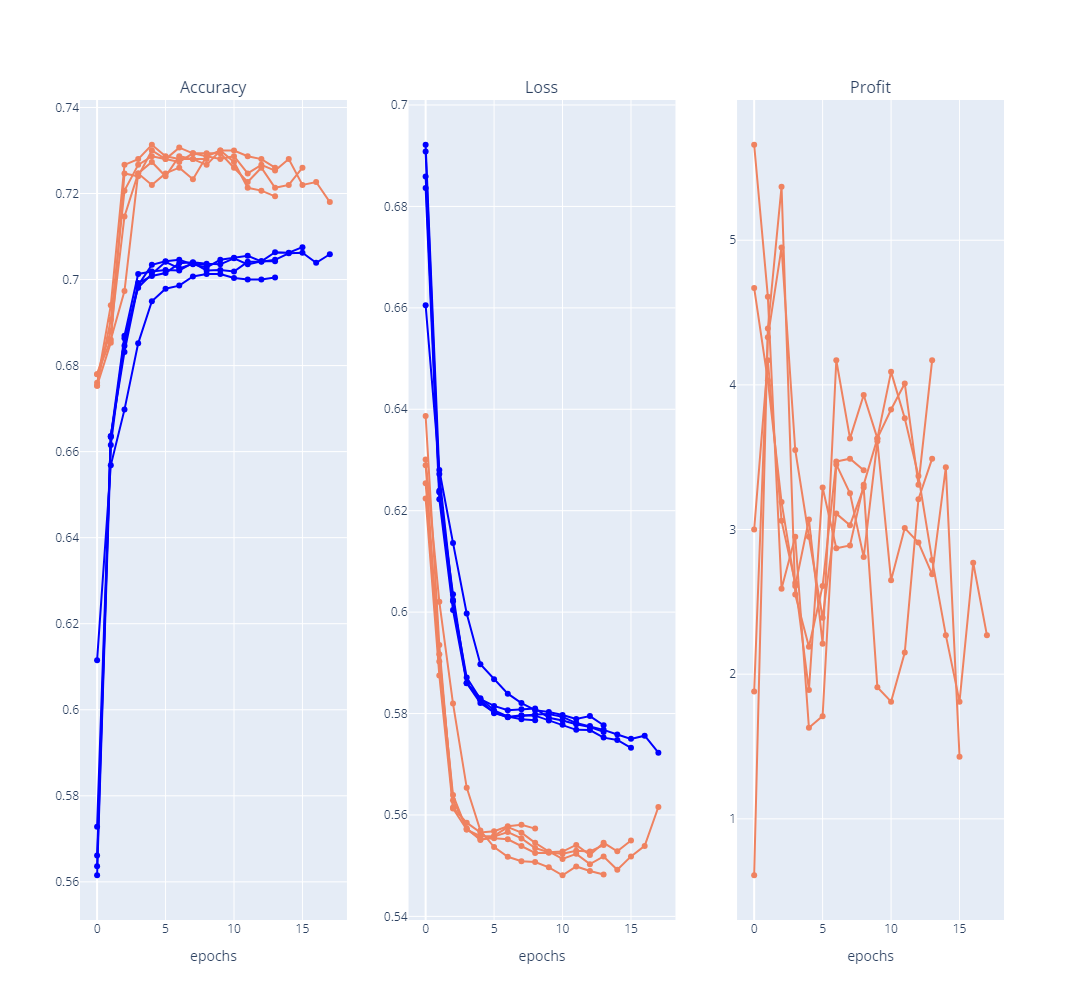

100 Timestep test start...
Train shape: (8500, 100, 4)
Timesteps: 100
Train Samples: 8500
Test Samples: 1500
Num features: 4
Repeat 0 running...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_106 (LSTM)                 │ (None, 100, 150)       │        93,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_105 (Dropout)           │ (None, 100, 150)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_107 (LSTM)                 │ (None, 150)            │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_106 (Dropout)           │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_70 (Dense)                │ (None, 75)             │        11,325 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_107 (Dropout)           │ (None, 75)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_71 (Dense)                │ (None, 2)              │           152 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 285,077 (1.09 MB)

 Trainable params: 285,077 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40

Epoch 1: val_loss improved from inf to 0.62921, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
New best model saved, previous best profit -> First
Profit: 3.38
133/133 - 6s - 41ms/step - accuracy: 0.6120 - loss: 0.6614 - val_accuracy: 0.6800 - val_loss: 0.6292
Epoch 2/40

Epoch 2: val_loss improved from 0.62921 to 0.60387, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
New best model saved, previous best profit -> 3.38
Profit: 3.45
133/133 - 3s - 26ms/step - accuracy: 0.6541 - loss: 0.6297 - val_accuracy: 0.6853 - val_loss: 0.6039
Epoch 3/40

Epoch 3: val_loss improved from 0.60387 to 0.58326, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Profit: 2.92
133/133 - 3s - 25ms/step - accuracy: 0.6686 - loss: 0.6146 - val_accuracy: 0.6960 - val_loss: 0.5833
Epoch 4/40

Epoch 4: val_loss improved from 0.58326 to 0.56673, saving model to ./saved

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_109 (LSTM)                 │ (None, 100, 150)       │        93,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_108 (Dropout)           │ (None, 100, 150)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_110 (LSTM)                 │ (None, 150)            │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_109 (Dropout)           │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 75)             │        11,325 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_110 (Dropout)           │ (None, 75)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 2)              │           152 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 285,077 (1.09 MB)

 Trainable params: 285,077 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40

Epoch 1: val_loss improved from inf to 0.62914, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
Profit: 3.49
133/133 - 6s - 42ms/step - accuracy: 0.5639 - loss: 0.6873 - val_accuracy: 0.6767 - val_loss: 0.6291
Epoch 2/40

Epoch 2: val_loss improved from 0.62914 to 0.59028, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Profit: 3.09
133/133 - 4s - 28ms/step - accuracy: 0.6636 - loss: 0.6241 - val_accuracy: 0.6867 - val_loss: 0.5903
Epoch 3/40

Epoch 3: val_loss improved from 0.59028 to 0.56558, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Profit: 3.45
133/133 - 4s - 27ms/step - accuracy: 0.6845 - loss: 0.6033 - val_accuracy: 0.7167 - val_loss: 0.5656
Epoch 4/40

Epoch 4: val_loss improved from 0.56558 to 0.55651, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Profit: 2.91
133/133 - 4s - 28ms/

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_112 (LSTM)                 │ (None, 100, 150)       │        93,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_111 (Dropout)           │ (None, 100, 150)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_113 (LSTM)                 │ (None, 150)            │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_112 (Dropout)           │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_74 (Dense)                │ (None, 75)             │        11,325 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_113 (Dropout)           │ (None, 75)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 2)              │           152 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 285,077 (1.09 MB)

 Trainable params: 285,077 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40

Epoch 1: val_loss improved from inf to 0.61628, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
Profit: 3.74
133/133 - 6s - 45ms/step - accuracy: 0.5749 - loss: 0.6788 - val_accuracy: 0.6813 - val_loss: 0.6163
Epoch 2/40

Epoch 2: val_loss improved from 0.61628 to 0.58302, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Profit: 3.57
133/133 - 4s - 28ms/step - accuracy: 0.6660 - loss: 0.6193 - val_accuracy: 0.6927 - val_loss: 0.5830
Epoch 3/40

Epoch 3: val_loss improved from 0.58302 to 0.55876, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Profit: 4.05
133/133 - 4s - 27ms/step - accuracy: 0.6891 - loss: 0.5978 - val_accuracy: 0.7247 - val_loss: 0.5588
Epoch 4/40

Epoch 4: val_loss improved from 0.55876 to 0.55691, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Profit: 3.65
133/133 - 4s - 28ms/

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_115 (LSTM)                 │ (None, 100, 150)       │        93,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_114 (Dropout)           │ (None, 100, 150)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_116 (LSTM)                 │ (None, 150)            │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_115 (Dropout)           │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 75)             │        11,325 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_116 (Dropout)           │ (None, 75)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 2)              │           152 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 285,077 (1.09 MB)

 Trainable params: 285,077 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40

Epoch 1: val_loss improved from inf to 0.64338, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Profit: 0.37
133/133 - 6s - 44ms/step - accuracy: 0.5627 - loss: 0.6978 - val_accuracy: 0.6727 - val_loss: 0.6434
Epoch 2/40

Epoch 2: val_loss improved from 0.64338 to 0.59533, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Profit: 4.01
133/133 - 4s - 27ms/step - accuracy: 0.6616 - loss: 0.6274 - val_accuracy: 0.6860 - val_loss: 0.5953
Epoch 3/40

Epoch 3: val_loss improved from 0.59533 to 0.56685, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Profit: 2.49
133/133 - 4s - 28ms/step - accuracy: 0.6807 - loss: 0.6061 - val_accuracy: 0.7173 - val_loss: 0.5668
Epoch 4/40

Epoch 4: val_loss improved from 0.56685 to 0.56189, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Profit: 1.91
133/133 - 4s - 27ms/

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_118 (LSTM)                 │ (None, 100, 150)       │        93,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_117 (Dropout)           │ (None, 100, 150)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_119 (LSTM)                 │ (None, 150)            │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_118 (Dropout)           │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ (None, 75)             │        11,325 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_119 (Dropout)           │ (None, 75)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 2)              │           152 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 285,077 (1.09 MB)

 Trainable params: 285,077 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40

Epoch 1: val_loss improved from inf to 0.62172, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Profit: 3.41
133/133 - 6s - 44ms/step - accuracy: 0.5759 - loss: 0.6823 - val_accuracy: 0.6787 - val_loss: 0.6217
Epoch 2/40

Epoch 2: val_loss improved from 0.62172 to 0.58669, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Profit: 3.65
133/133 - 3s - 22ms/step - accuracy: 0.6654 - loss: 0.6215 - val_accuracy: 0.6913 - val_loss: 0.5867
Epoch 3/40

Epoch 3: val_loss improved from 0.58669 to 0.56159, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Profit: 1.87
133/133 - 3s - 25ms/step - accuracy: 0.6888 - loss: 0.5991 - val_accuracy: 0.7233 - val_loss: 0.5616
Epoch 4/40

Epoch 4: val_loss improved from 0.56159 to 0.55883, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Profit: 2.99
133/133 - 3s - 25ms/

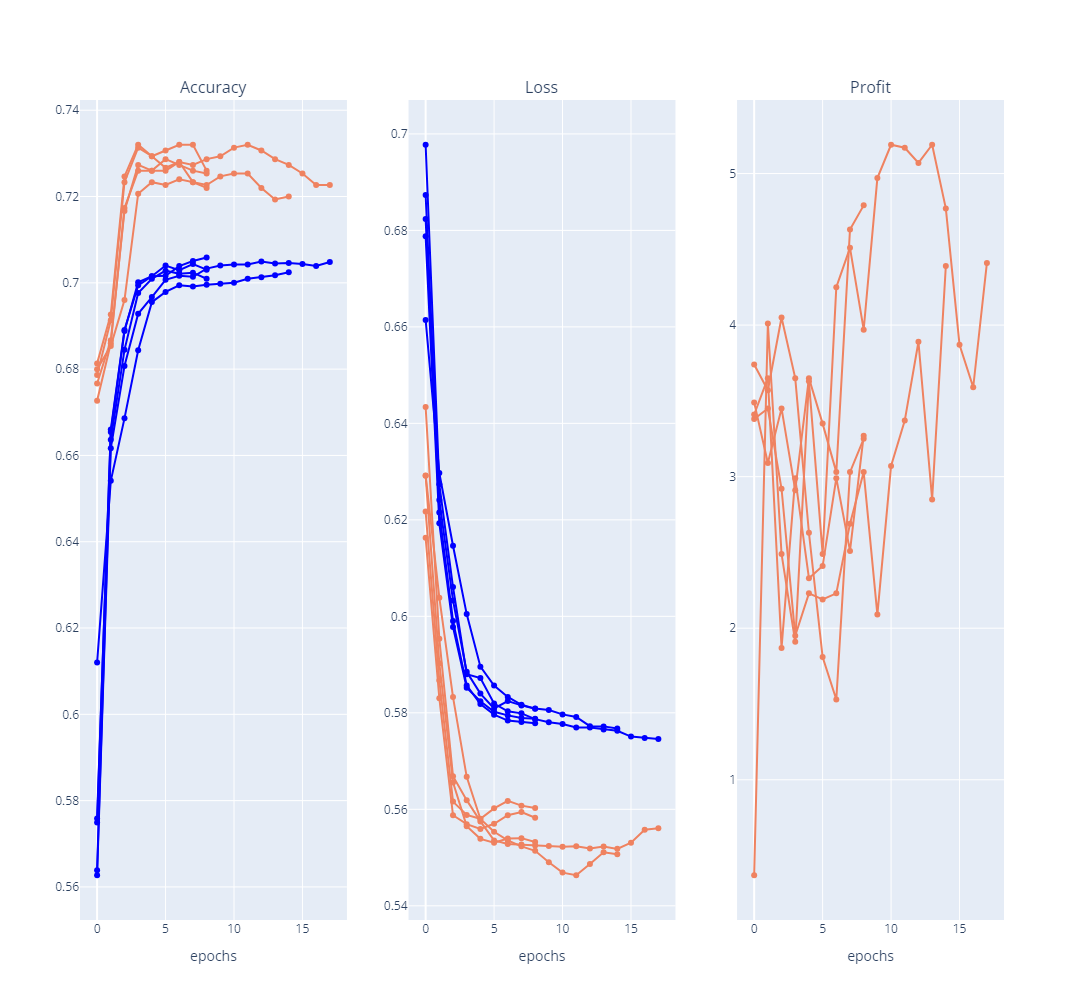

150 Timestep test start...
Train shape: (8500, 150, 4)
Timesteps: 150
Train Samples: 8500
Test Samples: 1500
Num features: 4
Repeat 0 running...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_121 (LSTM)                 │ (None, 150, 150)       │        93,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_120 (Dropout)           │ (None, 150, 150)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_122 (LSTM)                 │ (None, 150)            │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_121 (Dropout)           │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 75)             │        11,325 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_122 (Dropout)           │ (None, 75)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 2)              │           152 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 285,077 (1.09 MB)

 Trainable params: 285,077 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40

Epoch 1: val_loss improved from inf to 0.63150, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
New best model saved, previous best profit -> First
Profit: 3.4
133/133 - 8s - 57ms/step - accuracy: 0.6151 - loss: 0.6598 - val_accuracy: 0.6773 - val_loss: 0.6315
Epoch 2/40

Epoch 2: val_loss improved from 0.63150 to 0.60069, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
New best model saved, previous best profit -> 3.4
Profit: 4.03
133/133 - 5s - 37ms/step - accuracy: 0.6575 - loss: 0.6268 - val_accuracy: 0.6853 - val_loss: 0.6007
Epoch 3/40

Epoch 3: val_loss improved from 0.60069 to 0.58153, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Profit: 2.7
133/133 - 4s - 33ms/step - accuracy: 0.6693 - loss: 0.6132 - val_accuracy: 0.6980 - val_loss: 0.5815
Epoch 4/40

Epoch 4: val_loss improved from 0.58153 to 0.56505, saving model to ./saved_

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_124 (LSTM)                 │ (None, 150, 150)       │        93,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_123 (Dropout)           │ (None, 150, 150)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_125 (LSTM)                 │ (None, 150)            │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_124 (Dropout)           │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 75)             │        11,325 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_125 (Dropout)           │ (None, 75)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 2)              │           152 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 285,077 (1.09 MB)

 Trainable params: 285,077 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40

Epoch 1: val_loss improved from inf to 0.63545, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Profit: 2.4
133/133 - 6s - 48ms/step - accuracy: 0.5653 - loss: 0.6938 - val_accuracy: 0.6773 - val_loss: 0.6354
Epoch 2/40

Epoch 2: val_loss improved from 0.63545 to 0.59290, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
New best model saved, previous best profit -> 4.03
Profit: 4.81
133/133 - 5s - 34ms/step - accuracy: 0.6618 - loss: 0.6253 - val_accuracy: 0.6893 - val_loss: 0.5929
Epoch 3/40

Epoch 3: val_loss improved from 0.59290 to 0.56206, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Profit: 3.51
133/133 - 5s - 35ms/step - accuracy: 0.6845 - loss: 0.6028 - val_accuracy: 0.7227 - val_loss: 0.5621
Epoch 4/40

Epoch 4: val_loss improved from 0.56206 to 0.55715, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_127 (LSTM)                 │ (None, 150, 150)       │        93,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_126 (Dropout)           │ (None, 150, 150)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_128 (LSTM)                 │ (None, 150)            │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_127 (Dropout)           │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_84 (Dense)                │ (None, 75)             │        11,325 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_128 (Dropout)           │ (None, 75)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 2)              │           152 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 285,077 (1.09 MB)

 Trainable params: 285,077 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40

Epoch 1: val_loss improved from inf to 0.62176, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
Profit: 4.24
133/133 - 7s - 55ms/step - accuracy: 0.5655 - loss: 0.6848 - val_accuracy: 0.6793 - val_loss: 0.6218
Epoch 2/40

Epoch 2: val_loss improved from 0.62176 to 0.58918, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Profit: 4.33
133/133 - 4s - 33ms/step - accuracy: 0.6625 - loss: 0.6238 - val_accuracy: 0.6873 - val_loss: 0.5892
Epoch 3/40

Epoch 3: val_loss improved from 0.58918 to 0.56147, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Profit: 2.77
133/133 - 5s - 35ms/step - accuracy: 0.6858 - loss: 0.6021 - val_accuracy: 0.7247 - val_loss: 0.5615
Epoch 4/40

Epoch 4: val_loss improved from 0.56147 to 0.55883, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Profit: 2.47
133/133 - 5s - 35ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_130 (LSTM)                 │ (None, 150, 150)       │        93,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_129 (Dropout)           │ (None, 150, 150)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_131 (LSTM)                 │ (None, 150)            │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_130 (Dropout)           │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 75)             │        11,325 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_131 (Dropout)           │ (None, 75)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 2)              │           152 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 285,077 (1.09 MB)

 Trainable params: 285,077 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40

Epoch 1: val_loss improved from inf to 0.62346, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
Profit: 3.69
133/133 - 7s - 54ms/step - accuracy: 0.5631 - loss: 0.6875 - val_accuracy: 0.6780 - val_loss: 0.6235
Epoch 2/40

Epoch 2: val_loss improved from 0.62346 to 0.58890, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Profit: 3.87
133/133 - 5s - 35ms/step - accuracy: 0.6632 - loss: 0.6231 - val_accuracy: 0.6887 - val_loss: 0.5889
Epoch 3/40

Epoch 3: val_loss improved from 0.58890 to 0.56276, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Profit: 3.57
133/133 - 4s - 33ms/step - accuracy: 0.6854 - loss: 0.6023 - val_accuracy: 0.7187 - val_loss: 0.5628
Epoch 4/40

Epoch 4: val_loss improved from 0.56276 to 0.55846, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Profit: 2.51
133/133 - 5s - 34ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_44"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_133 (LSTM)                 │ (None, 150, 150)       │        93,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_132 (Dropout)           │ (None, 150, 150)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_134 (LSTM)                 │ (None, 150)            │       180,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_133 (Dropout)           │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ (None, 75)             │        11,325 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_134 (Dropout)           │ (None, 75)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_89 (Dense)                │ (None, 2)              │           152 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 285,077 (1.09 MB)

 Trainable params: 285,077 (1.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40

Epoch 1: val_loss improved from inf to 0.62242, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Profit: 4.3
133/133 - 7s - 49ms/step - accuracy: 0.5635 - loss: 0.6876 - val_accuracy: 0.6780 - val_loss: 0.6224
Epoch 2/40

Epoch 2: val_loss improved from 0.62242 to 0.58981, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Profit: 4.43
133/133 - 4s - 32ms/step - accuracy: 0.6640 - loss: 0.6231 - val_accuracy: 0.6880 - val_loss: 0.5898
Epoch 3/40

Epoch 3: val_loss improved from 0.58981 to 0.56311, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Profit: 4.09
133/133 - 4s - 32ms/step - accuracy: 0.6853 - loss: 0.6013 - val_accuracy: 0.7227 - val_loss: 0.5631
Epoch 4/40

Epoch 4: val_loss improved from 0.56311 to 0.56138, saving model to ./saved_models/last_saved_model.keras
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Profit: 2.15
133/133 - 4s - 30ms/s

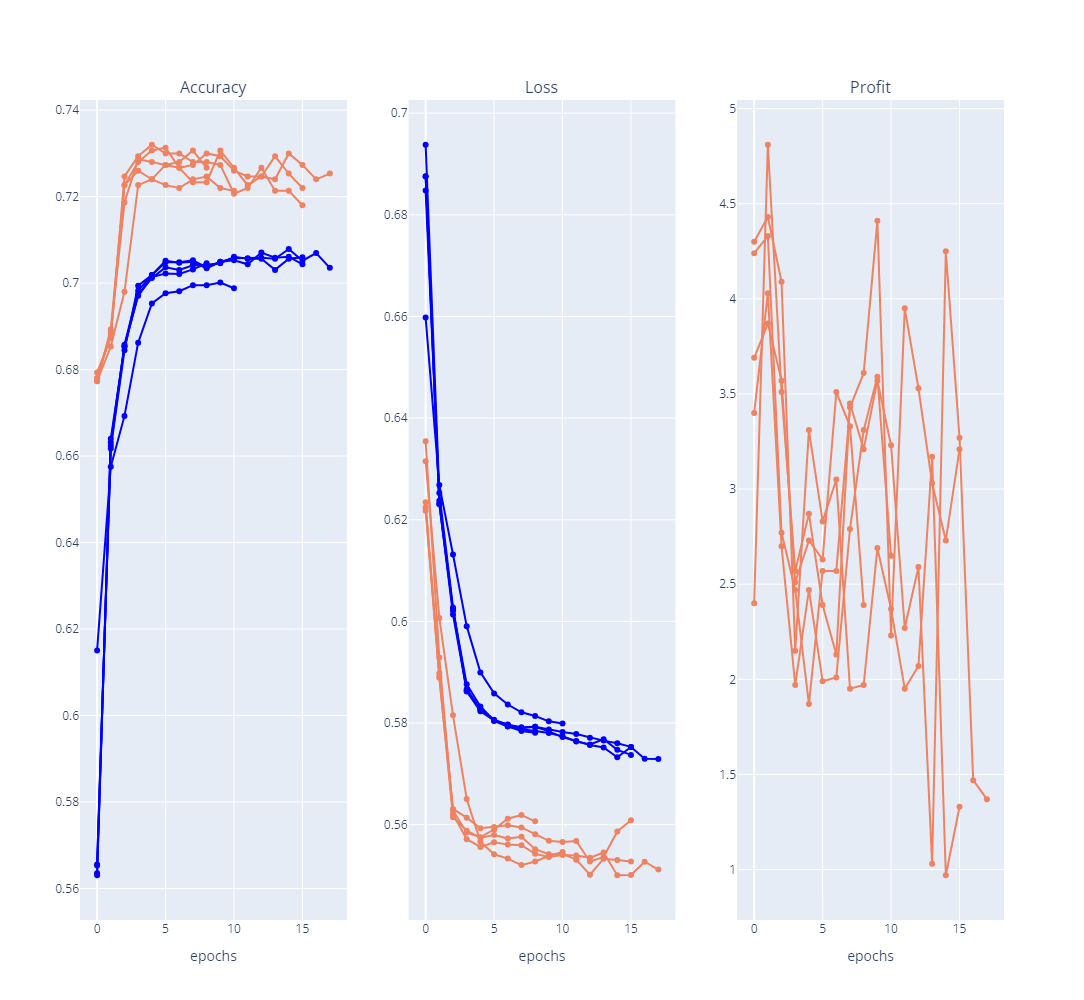

              10         20         50        100        150
count   5.000000   5.000000   5.000000   5.000000   5.000000
mean   72.813333  72.373333  72.853333  72.800000  72.666667
std     0.207631   0.443722   0.212916   0.169968   0.244950
min    72.600001  71.733332  72.600001  72.533333  72.399998
25%    72.666669  72.200000  72.733331  72.733331  72.466666
50%    72.799999  72.466666  72.799999  72.866666  72.666669
75%    72.866666  72.533333  73.000002  72.933334  72.799999
max    73.133332  72.933334  73.133332  72.933334  73.000002
             10        20        50      100       150
count  5.000000  5.000000  5.000000  5.00000  5.000000
mean   4.114000  3.970000  2.602000  3.29000  3.074000
std    1.079759  0.797747  0.792162  0.94308  0.836349
min    3.190000  2.910000  1.810000  2.33000  2.070000
25%    3.430000  3.630000  2.190000  2.63000  2.730000
50%    3.650000  3.890000  2.270000  3.35000  2.790000
75%    4.450000  4.390000  2.910000  3.37000  3.530000
max    5.85

In [74]:
# Run
from numpy import dtype

repeats = 5
testingParameter = "Timestep"
runMeter = 0
results_acc = DataFrame(dtype='float')
results_profit = DataFrame(dtype='float')
results_profitOld = DataFrame(dtype='float')
metrics = list()

# vary training epochs
learning_rate = 0.001
model = 2 # [0, 1, 2, 3, 4]
dropout = 0 # [0, 0.2, 0.4, 0.6, 0.8]
denseType = 0
neuronsLstm = 150
epochs = 40

timeStep = [10, 20, 50, 100, 150] # 150
features = 0

# # Data gen
# x_train, x_test, y_train, y_test, Y_test = data(timeStep, features)

# for dr in dropout:
for tim in timeStep:
    print(f"{tim} {testingParameter} test start...")

    #  Profit list
    profitListSaveModel = list()
    
    x_train, x_test, y_train, y_test, Y_test = data(tim, features)

    # Experiment
    results_acc[str(tim)], results_profit[str(tim)], results_profitOld[str(tim)], metrics = experiment(
                                                                                            runMeter, 
                                                                                            repeats, 
                                                                                            epochs, 
                                                                                            neuronsLstm, 
                                                                                            tim, 
                                                                                            denseType, 
                                                                                            dropout, 
                                                                                            model, 
                                                                                            features, 
                                                                                            learning_rate
                                                                                            )
    # runMeter commented if next loop parameter has different model weights  
    #  runMeter += 1

    plotsOut(tim, metrics)

# summarize results
print(results_acc.describe())
print(results_profit.describe())
print(results_profitOld.describe())

In [75]:
# summarize results
print(results_acc.describe())
print(results_profit.describe())

              10         20         50        100        150
count   5.000000   5.000000   5.000000   5.000000   5.000000
mean   72.813333  72.373333  72.853333  72.800000  72.666667
std     0.207631   0.443722   0.212916   0.169968   0.244950
min    72.600001  71.733332  72.600001  72.533333  72.399998
25%    72.666669  72.200000  72.733331  72.733331  72.466666
50%    72.799999  72.466666  72.799999  72.866666  72.666669
75%    72.866666  72.533333  73.000002  72.933334  72.799999
max    73.133332  72.933334  73.133332  72.933334  73.000002
             10        20        50      100       150
count  5.000000  5.000000  5.000000  5.00000  5.000000
mean   4.114000  3.970000  2.602000  3.29000  3.074000
std    1.079759  0.797747  0.792162  0.94308  0.836349
min    3.190000  2.910000  1.810000  2.33000  2.070000
25%    3.430000  3.630000  2.190000  2.63000  2.730000
50%    3.650000  3.890000  2.270000  3.35000  2.790000
75%    4.450000  4.390000  2.910000  3.37000  3.530000
max    5.85

              10         20         50        100        150
count   5.000000   5.000000   5.000000   5.000000   5.000000
mean   72.813333  72.373333  72.853333  72.800000  72.666667
std     0.207631   0.443722   0.212916   0.169968   0.244950
min    72.600001  71.733332  72.600001  72.533333  72.399998
25%    72.666669  72.200000  72.733331  72.733331  72.466666
50%    72.799999  72.466666  72.799999  72.866666  72.666669
75%    72.866666  72.533333  73.000002  72.933334  72.799999
max    73.133332  72.933334  73.133332  72.933334  73.000002


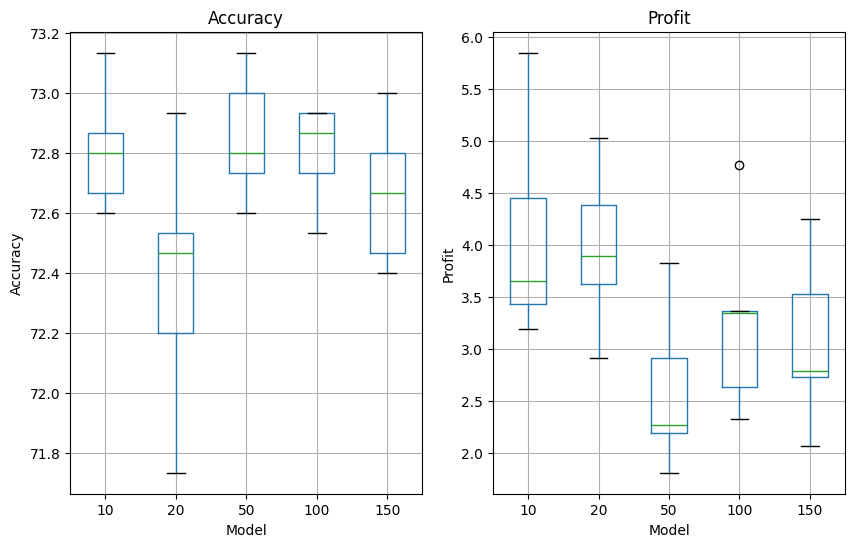

In [76]:
%matplotlib inline
print(results_acc.describe())

# 2 subplots in one row
fig, ax = plt.subplots(1, 2, figsize=(10, 6))

# Generate boxplots
results_acc.boxplot(ax=ax[0])
results_profit.boxplot(ax=ax[1])

# Set labels and titles
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Model')
ax[0].set_ylabel('Accuracy')
ax[1].set_title('Profit')
ax[1].set_xlabel('Model')
ax[1].set_ylabel('Profit')

# Save to .png and show plot
plt.savefig(f'boxplot_{testingParameter}.png')
plt.show()